In [8]:
import PyMieScatt as ps
from astropy.io import fits
from astropy import units as u
from astropy.modeling.models import BlackBody
from lmfit import Parameters, minimize
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
class IceCont():
    def __init__(self,datafile,opacfile=None):
        self.read_data(datafile)
        if opacfile:
            self.read_opac(opacfile)
        else:
            self.cext_int = 1
            
   #     self.fit_bb()
        self.fit_poly()
    
        self.plot_file(datafile)
        
    def read_data(self,datafile):
        colnames = ["Wavelength (um)","Flux (Jy)","Statistical Error (Jy)"]
        df = pd.read_csv(datafile,sep='\s+',skiprows=19,names=colnames)
        self.wave = df["Wavelength (um)"]
        self.fd = df["Flux (Jy)"]
        self.er = df["Statistical Error (Jy)"]
        
    def read_opac(self,opacfile):
        data_raw = fits.getdata(opacfile)
        wave_opac = data_raw['wavelength']
        cext      = data_raw['cext']
        
        ssubs = np.argsort(wave_opac)
        wave_opac = wave_opac[ssubs]
        cext = cext[ssubs]
        self.cext_int  = np.interp(self.wave,wave_opac,cext)

    def fit_poly(self):
        ranges = [(2.85,3.4),(3.6,4.0),(4.1,4.2)]
        fit_params = Parameters()
        fit_params.add('c0',value=1.0)
        fit_params.add('c1',value=1.0)
        fit_params.add('c2',value=0.0)
        fit_params.add('c3',value=0.0)
        fit_params.add('nd',value=1e-3)
        
        gsubs = []
        for range in ranges:
            gsubs = gsubs + np.where((self.wave>range[0]) & (self.wave<range[1]))[0].tolist()
        
        
        if isinstance(self.cext_int,int):
            self.cext_subs = self.cext_int
        else:
            self.cext_subs = self.cext_int[gsubs]
        
        out = minimize(self.residual, fit_params, args=(self.wave[gsubs],), kws={'data':self.fd[gsubs]})
        fit = self.residual(out.params, self.wave)
        cont_params = out.params
        print("tau:",cont_params['nd'].value)
        cont_params['nd'].value = 0.0
        cont = self.residual(cont_params, self.wave)
        self.fit = fit
        self.cont = cont
    
    def residual(self,pars,x,data=None,cext=1):
        for num in x:
            if num<0:
                print("error: negative number, x=",num)
            elif num==0:
                print("error: zero x=",num)
        
        cont = pars['c0'] + pars['c1']*x + pars['c2']*x**2 + pars['c3']*x**3
        if data is None:
            model = cont*np.exp(-self.cext_int*pars['nd'])
            return model
        else:
            model = cont*np.exp(-self.cext_subs*pars['nd'])
        return model-data
    
        
    def fit_bb(self):
        ranges = [(2.85,3.2),(3.65,4.0)]
        fit_params = Parameters()
        fit_params.add('const',value=1e7)
        fit_params.add('const_star',value=1e7)        
        fit_params.add('temp',value=1000,min=100,max=4000)
        fit_params.add('nd',value=1e-3,max=5,min=0)
        
        gsubs = []
        for range in ranges:
            gsubs = gsubs + np.where((self.wave>range[0]) & (self.wave<range[1]))[0].tolist()
        
        #self.cext_int -= np.min(self.cext_int[gsubs])
        self.cext_subs = self.cext_int[gsubs]
        
        out = minimize(self.residual_bb, fit_params, args=(self.wave[gsubs],), kws={'data':self.fd[gsubs]})
        fit = self.residual_bb(out.params, self.wave)
        cont_params = out.params
        print("tau:",cont_params['nd'].value)
        cont_params['nd'].value = 0.0
        cont = self.residual_bb(cont_params, self.wave)
        self.fit = fit
        self.cont = cont
    
    def residual_bb(self,pars,x,data=None,cext=None):
        bb = BlackBody(temperature=pars['temp']*u.K)
        cont = pars['const']*bb(x*u.micron).value
        bb = BlackBody(temperature=4000*u.K)
        star = pars['const_star']*bb(x*u.micron).value
        if data is None:
            model = (star+cont)*np.exp(-self.cext_int*pars['nd'])
            return model
        else:
            model = (star+cont)*np.exp(-self.cext_subs*pars['nd'])
        return model-data
    
    def plot_file(self,file):
        fig=plt.figure(1,figsize=(10,6))
        ax1=fig.add_subplot(111)
        ax1.plot(self.wave,self.fd)
        plt.plot(self.wave,self.fit)
        plt.plot(self.wave,self.cont)
        
        ax1.set_ylim(-0.1,0.6)
        ax1.set_xlabel("Wavelength (um)",fontsize=16)
        ax1.set_ylabel("Flux (Jy)",fontsize=16)
        ax1.set_title(file,fontsize=18)
    
 

753
tau: 1.644509758955824e-05


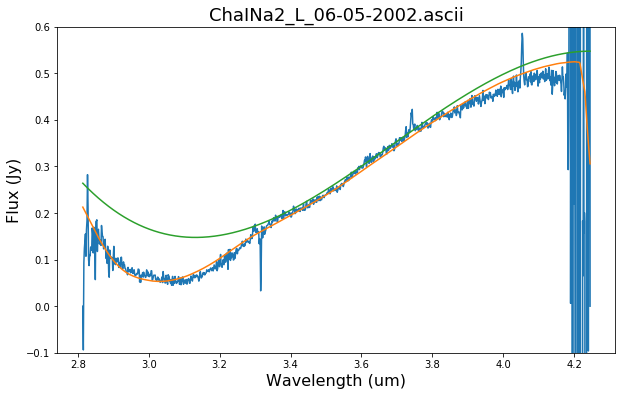

In [13]:
datafile = "ChaINa2_L_06-05-2002.ascii"
path = '/Users/clara/mypy/ross_thesis/jw_ice/opacities/'

amax_ind = 7
alpha_ind = 5
ice_thick_ind = 3
i = (amax_ind*100)+(alpha_ind*10)+ice_thick_ind
print(i)

opacfile = path+'opacity_'+str(i)+'.fits'
IceCont(file,opacfile)


753

tau: -1.0837331901058662


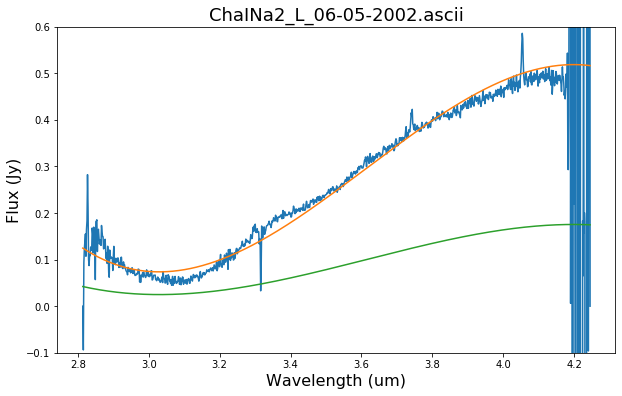

In [10]:
file = "ChaINa2_L_06-05-2002.ascii"
IceCont('ChaINa2_L_06-05-2002.ascii')